# Constructing approximations with <font size=5>[`Piecewise.piecewisefit`](https://ChristopheBerthod.github.io/Piecewise.jl/dev/index.html#Piecewise.piecewisefit)</font>

**[`Piecewise`](https://github.com/ChristopheBerthod/Piecewise.jl)** *Tutorial 1*<br>25-02-2025 | Christophe Berthod | University of Geneva, Switzerland

<div class="alert alert-block alert-success">This notebook can run on a laptop. It will typically take less than a minute to evaluate all cells on a single thread. A recent version of <a href="https://julialang.org" style="text-decoration:none"><code>Julia</code></a> is needed, complemented by the modules
<a href="https://github.com/JuliaMath/SpecialFunctions.jl" style="text-decoration:none"><code>SpecialFunctions</code></a>,
<a href="https://github.com/ChristopheBerthod/Piecewise.jl" style="text-decoration:none"><code>Piecewise</code></a>,
<a href="https://github.com/SciML/DataInterpolations.jl" style="text-decoration:none"><code>DataInterpolations</code></a>, and
<a href="https://github.com/JuliaMath/QuadGK.jl" style="text-decoration:none"><code>QuadGK</code></a>
for the math, as well as
<a href="https://github.com/JuliaPlots/Plots.jl" style="text-decoration:none"><code>Plots</code></a>,
<a href="https://github.com/JuliaStrings/LaTeXStrings.jl" style="text-decoration:none"><code>LaTeXStrings</code></a>, and
<a href="https://github.com/JuliaGraphics/Measures.jl" style="text-decoration:none"><code>Measures</code></a>
for plotting purposes.</div>

In [1]:
# Packages used in this notebook

using SpecialFunctions
using Piecewise
using DataInterpolations
using QuadGK
using Plots, LaTeXStrings, Measures
using Printf

**Context** – According to the quantum theory, the electrons behave like waves with a dispersion relation $\varepsilon(\mathbf{k})$ that depends on the environment in which these electrons move. Here $\mathbf{k}$ is a wavevector and $\varepsilon(\mathbf{k})$ is the energy of an electron having wavevector $\mathbf{k}$. One question arises: given an energy $E$, how many wavevectors $\mathbf{k}$ obey the condition $\varepsilon(\mathbf{k})=E\,$? The answer to this question is the *density of states* (DOS), a function $N(E)$ that counts the number of wavevectors at energy $E$. This function plays an important role in many electronic phenomena. The DOS may be defined using the [Dirac delta function](https://en.wikipedia.org/wiki/Dirac_delta_function) $\delta(\cdot)$ as $$N(E)=\displaystyle\int\frac{\mathrm{d}^dk}{(2\pi)^d}\,\delta\big(E-\varepsilon(\mathbf{k})\big),$$ where $d$ is the spatial dimension. The known properties of the delta function show that $N(E)$ has critical points whenever $\mathbf{\nabla}\varepsilon(\mathbf{k})=0$ for some $\mathbf{k}$. These critical points can be singularities, discontinuities, discontinuities of the first derivative, etc., depending on $\varepsilon(\mathbf{k})$ and the dimension $d$. In rare cases, the integral giving $N(E)$ is solvable exactly. Otherwise $N(E)$ requires a numerical integration. To speedup the calculations involving $N(E)$, it is desirable to have a fast, yet accurate approximation of $N(E)$.

**Contents of the notebook** – Here, to illustrate the use of the method [`Piecewise.piecewisefit`](https://ChristopheBerthod.github.io/Piecewise.jl/dev/index.html#Piecewise.piecewisefit), we first consider a case where $N(E)$ is known exactly and we construct approximations of increasing accuracies. Then, in order to illustrate the potential speedup that can be achieved by such approximations, we consider a case where the evaluation of $N(E)$ requires a one-dimensional quadrature. In both cases, we emphasize the difficuties encountered by standard polynomial interpolations near the critical points of $N(E)$. The two examples deal with two-dimensional systems ($d=2$).

## Isotropic square lattice

The dispersion relation $\varepsilon(\mathbf{k})=2J\left[\cos(k_xa)+\cos(k_ya)\right]$ corresponds to electrons making hops of energy $J$ on a discrete two-dimensional square lattice with lattice parameter $a$. It is convenient to use $a$ as the unit of length and $J$ as the unit of energy: Hereafter, we therefore set $a=1$ and $J=1$. The DOS is known exactly in this case, $N(E)=K\big(1-(E/4)^2\big)\theta(4-|E|)/(2\pi^2)$, with $K(\cdot)$ the [complete elliptic integral of the first kind](https://mathworld.wolfram.com/CompleteEllipticIntegraloftheFirstKind.html) and $\theta(\cdot)$ the [Heaviside step function](https://en.wikipedia.org/wiki/Heaviside_step_function). $N(E)$ has two discontinuities at $E=\pm4$ and a logarithmic singularity at $E=0$.

#### Avoid fitting formula to noise

$K(\cdot)$ is provided by [`SpecialFunctions.ellipk`](https://specialfunctions.juliamath.org/stable/functions_list/#SpecialFunctions.ellipk). Since we are going to fit trial functions to $N(E)$, it is important to make sure that the numerical implementation of $N(E)$ is noiseless, otherwise the algorithm will be trapped fitting functions to noise. (The method [`piecewisefit`](https://ChristopheBerthod.github.io/Piecewise.jl/dev/index.html#Piecewise.piecewisefit) takes an optional argument `grain` that can also help mitigating this problem). It turns out that `ellipk(1 - (E / 4)^2)` loses accuracy for $|E|\lesssim10^{-4}$. The exact behavior of $K\big(1-(E/4)^2\big)$ for $|E|\to0$ is $\ln(16/|E|)$. The following graph shows that `ellipk(1 - (E / 4)^2)` indeed approaches `log(16 / abs(E))` for $|E|<10^{-3}$, but then it becomes noisy for $|E|\lesssim10^{-4}$. We therefore use the expression $\ln(16/|E|)$ for $|E|<10^{-4}$ in the definition of $N(E)$.

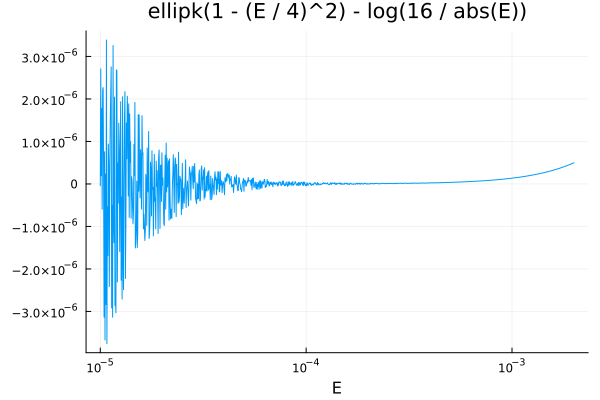

In [2]:
E = logrange(1e-5, 2e-3, 1000)
plot(xscale=:log10, xlabel="E", title="ellipk(1 - (E / 4)^2) - log(16 / abs(E))", legend=:none)
plot!(E, (@. ellipk(1 - (E / 4)^2) - log(16 / abs(E))))

In [3]:
# DOS function
N(E) = (abs(E) < 1e-4 ? log(16 / abs(E)) : abs(E) > 4 ? 0.0 : ellipk(1 - (E / 4)^2)) / (2 * π^2)

N (generic function with 1 method)

#### Fit formula to smooth rather than singular functions

[`piecewisefit`](https://ChristopheBerthod.github.io/Piecewise.jl/dev/index.html#Piecewise.piecewisefit) is obviously more likely to succeed with functions that are smooth. Rather than fitting $N(E)$ directly, it is preferable to remove the known logarithmic singularity from $N(E)$ before fitting, and adding it back afterwards. In this way, the function passed to [`piecewisefit`](https://ChristopheBerthod.github.io/Piecewise.jl/dev/index.html#Piecewise.piecewisefit) is smooth. This is possible, because [`PiecewiseFunction`](https://ChristopheBerthod.github.io/Piecewise.jl/dev/index.html#Piecewise.PiecewiseFunction) objects behave like functions, and they can also be added to produce new piecewise functions. The logarithmic singularity that we subtract is simply $-\ln|E|/(2\pi^2)$, which can be represented by the [`Formula`](https://ChristopheBerthod.github.io/Piecewise.jl/dev/index.html#Piecewise.Formula) called [`LOG`](https://ChristopheBerthod.github.io/Piecewise.jl/dev/index.html#Piecewise.LOG). After removing the singularity, we fit a polynomial function called [`POLY`](https://ChristopheBerthod.github.io/Piecewise.jl/dev/index.html#Piecewise.POLY) to the rest. With the requested accuracy, the fitting succeeds with a *single* piece. The fitting needs only be done once: the method [`print`](https://ChristopheBerthod.github.io/Piecewise.jl/dev/index.html#Printf.format) displays the constructor of a piecewise function, which can be copy-pasted in a text file.

In [4]:
# Piecewise function representing the logarithmic singularity
singularity = PiecewiseFunction(:even, Piece((0, 4), (false, true), LOG, [0, -1 / (2 * π^2)]))

# Fitting a polynomial to the smooth part
background = piecewisefit(E -> N(E) - singularity(E), (0, 4), [POLY], parity=:even, rtol=5e-6)

# Adding back the singularity. f(E) is now our approximation of N(E)
f = background + singularity

< Piecewise even function with 1 piece and support [-4.0, 4.0] >

In [5]:
print(f)

PiecewiseFunction(:even, [
    Piece((0.0, 4.0), (false, true), [POLY, LOG],
        [[1.404609620501190e-01, 1.174637035429226e-04, 2.462481494550580e-03,
        -1.995071066188710e-03, 1.349285972938791e-03, -6.607932328050266e-04,
        2.158678002194439e-04, -4.417944490900440e-05, 5.103263826816860e-06,
        -2.533300200247781e-07], [0.000000000000000e+00,
        -5.066059182116889e-02]])
])

The top-left graph below shows the smooth part `N(E) - singularity(E)` and its one-piece approximation. The bottom-left shows that the relative difference between the function and the approximation is smaller than $10^{-5}$. The right graph shows the DOS and its piecewise approximation.

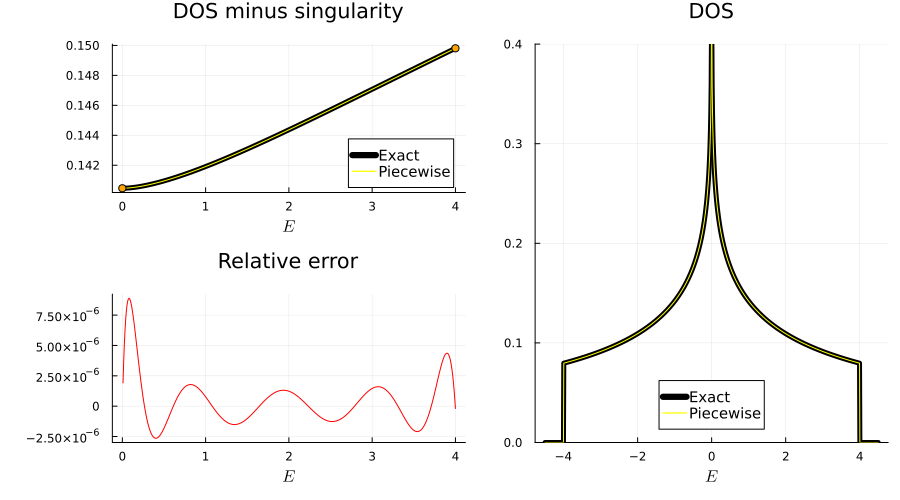

In [6]:
function show()

    p1 = plot(xlabel=L"E", title="DOS minus singularity", legend=:bottomright, legendfontsize=10)
    E = LinRange(0, 4, 500)
    plot!(p1, E, N.(E) .- singularity.(E), lw=5, c=:black, label="Exact")
    plot!(p1, E, background.(E), lw=1, c=:yellow, label="Piecewise")
    E = [p.domain[1] for p in background.pieces]; push!(E, background.pieces[end].domain[2])
    scatter!(p1, E, background.(E), c=:orange, label=:none)

    p2 = plot(xlabel=L"E", title="Relative error", legend=:none)
    E = LinRange(0, 4, 500)
    plot!(p2, E, (@. f(E) / N(E) - 1), c=:red)

    p3 = plot(xlabel=L"E", ylims=(0, 0.4), title="DOS", legend=:bottom, legendfontsize=10)
    E = LinRange(-4.5, 4.5, 1000)
    plot!(p3, E, N.(E), lw=5, c=:black, label="Exact")
    plot!(p3, E, f.(E), lw=1, c=:yellow, label="Piecewise")

    return plot(plot(p1, p2, layout = (2, 1), margins=5mm), p3, size = (900, 500))

end

show()

Requesting higher accuracy, we get an approximation with about ten pieces and less that $10^{-7}$ relative error. Note that the error is largest close to $E=4$. In order to increase the sampling in that region, we can use the optional argument `cuts` of [`piecewisefit`](https://ChristopheBerthod.github.io/Piecewise.jl/dev/index.html#Piecewise.piecewisefit). Uncomment the corresponding line to see the effect. Note also that the results may vary from one run to the next, because randomness is involved in the fitting process.

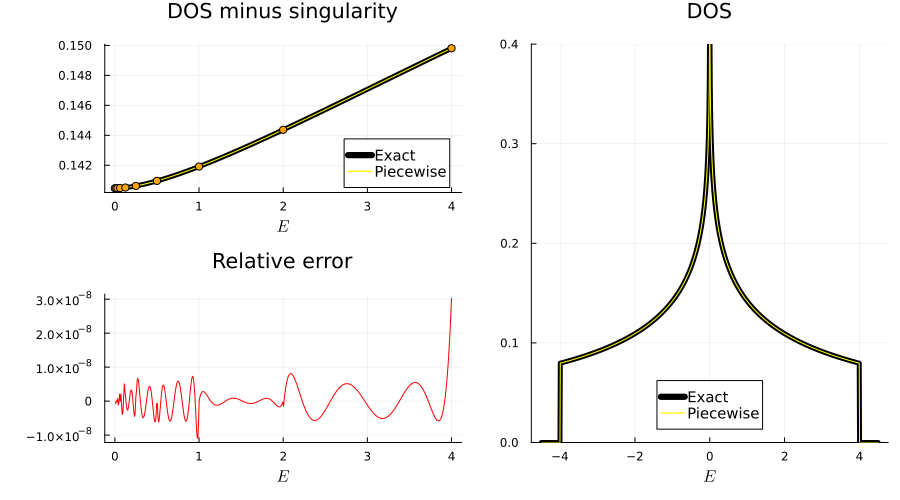

In [7]:
# Fitting with relative tolerance of 1e-8
background = piecewisefit(E -> N(E) - singularity(E), (0, 4), [POLY], parity=:even, rtol=1e-8)

# Imposing a cut very close to E = 4.
#background = piecewisefit(E -> N(E) - singularity(E), (0, 4), [POLY], parity=:even, cuts=[4 - 1e-4], rtol=1e-8)

f = background + singularity
show()

#### Check polynomial interpolations near critical points

Here, we use [`DataInterpolations.jl`](https://docs.sciml.ai/DataInterpolations/stable/) to display the problems potentially encountered by polynomial interpolations near critical points. For simplicity, the interpolations are constructed with a uniform grid of 1000 points. Cheaper and better approximations could be constructed using optimized nonuniform grids.


Size of interpolations     (bytes): [24360, 32328, 16312]
Size of piecewise function (bytes): 7898



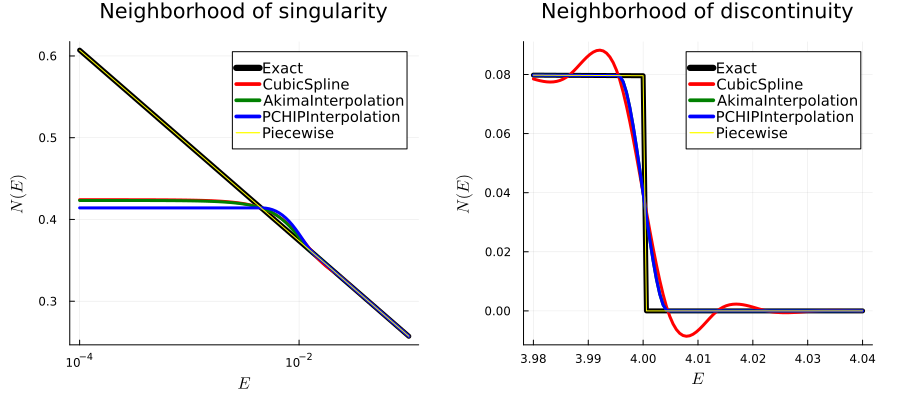

In [8]:
# Build polynomial interpolations using various models
E = LinRange(-4.5, 4.5, 1000)
g = [interp(N.(E), E) for interp in [CubicSpline, AkimaInterpolation, PCHIPInterpolation]]

# Show memory cost of approximations
print("""

Size of interpolations     (bytes): $(Base.summarysize.(g))
Size of piecewise function (bytes): $(Base.summarysize(f))

""")

# Compare the interpolations with N(E) close to the logarithmic singularity
p1 = plot(xscale=:log10, xlabel=L"E", ylabel=L"N(E)", title="Neighborhood of singularity", legend=:topright, legendfontsize=10)
E = logrange(1e-4, 1e-1, 100)
plot!(p1, E, N.(E), lw=5, c=:black, label="Exact")
plot!(p1, E, g[1].(E), lw=3, c=:red, label="CubicSpline")
plot!(p1, E, g[2].(E), lw=3, c=:green, label="AkimaInterpolation")
plot!(p1, E, g[3].(E), lw=3, c=:blue, label="PCHIPInterpolation")
plot!(p1, E, f.(E), lw=1, c=:yellow, label="Piecewise")

# Compare the interpolations with N(E) close to the discontinuity
p2 = plot(xlabel=L"E", ylabel=L"N(E)", title="Neighborhood of discontinuity", legend=:topright, legendfontsize=10)
E = LinRange(3.98, 4.04, 100)
plot!(p2, E, N.(E), lw=5, c=:black, label="Exact")
plot!(p2, E, g[1].(E), lw=3, c=:red, label="CubicSpline")
plot!(p2, E, g[2].(E), lw=3, c=:green, label="AkimaInterpolation")
plot!(p2, E, g[3].(E), lw=3, c=:blue, label="PCHIPInterpolation")
plot!(p2, E, f.(E), lw=1, c=:yellow, label="Piecewise")

plot(p1, p2, size = (900, 400), margins=5mm)

## Anisotropic square lattice

If the energy of the electron hop is $J$ in the $x$ direction and $\alpha J$ in the $y$ direction, the dispersion becomes $\varepsilon(\mathbf{k})=2J[\cos(k_xa)+\alpha\cos(k_ya)]$. We assume $0<\alpha<1$ for definiteness. With just this little change with respect to the isotropic square lattice, a simple exact formula for the DOS is unknown (to the author). The DOS can be recast as a one-dimensional integral (see **Appendix**),
	\begin{equation*}
		N(E)=\frac{1}{2\pi^2}\int_{\cos^{-1}\Big(\min\big(+1,(E/2+1)/\alpha\big)\Big)}
        ^{\cos^{-1}\Big(\max\big(-1,(E/2-1)/\alpha\big)\Big)}
        \frac{d\theta}{\sqrt{1-\left(E/2-\alpha\cos\theta\right)^2}},
	\end{equation*}
that we evaluate using a Gauss quadrature provided by [`QuadGK.quadgk`](https://juliamath.github.io/QuadGK.jl/stable/api/#QuadGK.quadgk).

In [9]:
# DOS function
function N(E, α; tol=1e-8)
    # No integral to perform if |E| >= 2 * (1 + α)
    abs(E) < 2 * (1 + α) || return 0.0
    # !! 1 - (E / 2 - α * cos(θ))^2 could be 0.0 due to rounding errors
    integrand(θ) = 1 / sqrt(abs(1 - (E / 2 - α * cos(θ))^2) + eps(Float64))
    int = quadgk(integrand, acos(min(1, (E / 2 + 1) / α)), acos(max(-1, (E / 2 - 1) / α)); rtol = tol / 10)
    if int[2] / int[1] > tol
        e = @sprintf("%.1e", int[2] / int[1])
        @warn "Integral not converged in N($(E), $(α); tol=$(tol)) [error = $(e)]"
    end
    return int[1] / (2 * π^2)
end

N (generic function with 2 methods)

Even without an exact formula, we can study the behavior and the critical points of the DOS. $N(E)$ is an even function of $E$ with two discontinuities at $|E|=\pm2(1+\alpha)$ and two logarithmic singularities at $|E|=\pm2(1-\alpha)$. The behavior close to the logarithmic singularity at positive $E$ is (see **Appendix**) $$N\big(E\to2(1-\alpha)\big)=-\frac{1}{4\pi^2\sqrt{\alpha}}\ln|E-2\left(1-\alpha\right)|.$$ Like in the isotropic case, we subtract this singularity before calling [`piecewisefit`](https://ChristopheBerthod.github.io/Piecewise.jl/dev/index.html#Piecewise.piecewisefit).

In [10]:
# Piecewise function representing the logarithmic singularity
function singularityα(α)
    s, b = 2 * (1 - α), 2 * (1 + α)
    return PiecewiseFunction(:even, [
        Piece((0, s), (true, false), LOG, [s, -1 / (4 * π^2 * sqrt(α))]),
        Piece((s, b), (false, true), LOG, [s, -1 / (4 * π^2 * sqrt(α))])
        ])
end

# Function to perform the fit, display the results, and return the approximation
function show(α, formula, rtol; kwargs...)

    background = piecewisefit(E -> N(E, α) - singularityα(α)(E), (0, 2 * (1 + α)),
        formula, parity=:even, rtol=rtol; kwargs...)

    f = background + singularityα(α)

    p1 = plot(xlabel=L"E", title="DOS minus singularity", legend=:top, legendfontsize=10)
    E = LinRange(0, 2 * (1 + α) - eps(Float32), 500)
    plot!(p1, E, N.(E, α) .- singularityα(α).(E), lw=5, c=:black, label="Exact")
    plot!(p1, E, background.(E), lw=1, c=:yellow, label="Piecewise")
    E = [p.domain[1] for p in background.pieces]; push!(E, background.pieces[end].domain[2])
    scatter!(p1, E, background.(E), c=:orange, label=:none)

    p2 = plot(xlabel=L"E", title="Relative error", legend=:none)
    E = LinRange(0, 2 * (1 + α) - eps(Float32), 500)
    plot!(p2, E, (@. f(E) / N(E, α) - 1), c=:red)

    p3 = plot(xlabel=L"E", ylims=(0, 3 * f(2 * (1 + α))), title="DOS (α = $(α))", legend=:bottom, legendfontsize=10)
    E = LinRange(-2.1 * (1 + α), 2.1 * (1 + α), 1000)
    plot!(p3, E, N.(E, α), lw=5, c=:black, label="Exact")
    plot!(p3, E, f.(E), lw=1, c=:yellow, label="Piecewise")

    plot(plot(p1, p2, layout = (2, 1), margins=5mm), p3, size = (900, 500))
    display(current())

    return f

end
;

A quick test with low accuracy reveals that the neighborhood of the (removed) singularity is where the background function varies the most.

┌ Warning: Integral not converged in N(-2.3989189189189193, 0.2; tol=1.0e-8) [error = 2.1e-08]
└ @ Main In[9]:10


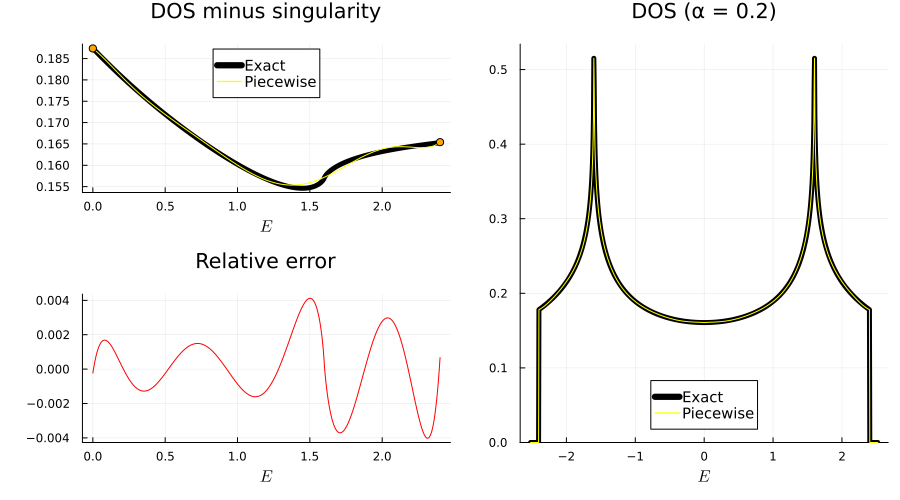

< Piecewise even function with 2 pieces and support [-2.4, 2.4] >

In [11]:
f = show(0.2, [POLY], 1e-2)

One can therefore help the fitting algorithm by adding a few cuts in this region. The strategy is to adjust the cuts such as to minimize the relative difference. After a little bit of trial and error, one finds an approximation with typically 4 pieces that matches the DOS with relative accuracy better than $10^{-4}$.

┌ Warning: Integral not converged in N(1.6000001192092896, 0.2; tol=1.0e-8) [error = 5.9e-08]
└ @ Main In[9]:10
┌ Warning: Integral not converged in N(-2.3989189189189193, 0.2; tol=1.0e-8) [error = 2.1e-08]
└ @ Main In[9]:10


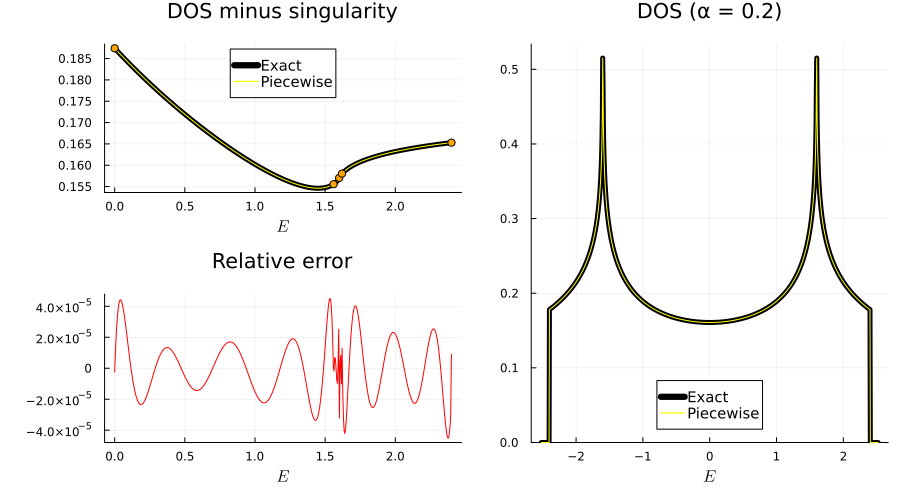

< Piecewise even function with 4 pieces and support [-2.4, 2.4] >

In [12]:
f = show(0.2, [POLY, TAIL], 1e-4, cuts=[1.56, 1.6, 1.62])

Let us show again that the polynomial interpolations are not well-suited for describing critical points.

┌ Warning: Integral not converged in N(-2.394894894894895, 0.2; tol=1.0e-8) [error = 1.0e-08]
└ @ Main In[9]:10
┌ Warning: Integral not converged in N(-2.394894894894895, 0.2; tol=1.0e-8) [error = 1.0e-08]
└ @ Main In[9]:10
┌ Warning: Integral not converged in N(-2.394894894894895, 0.2; tol=1.0e-8) [error = 1.0e-08]
└ @ Main In[9]:10



Size of interpolations     (bytes): [24360, 32328, 16312]
Size of piecewise function (bytes): 3696



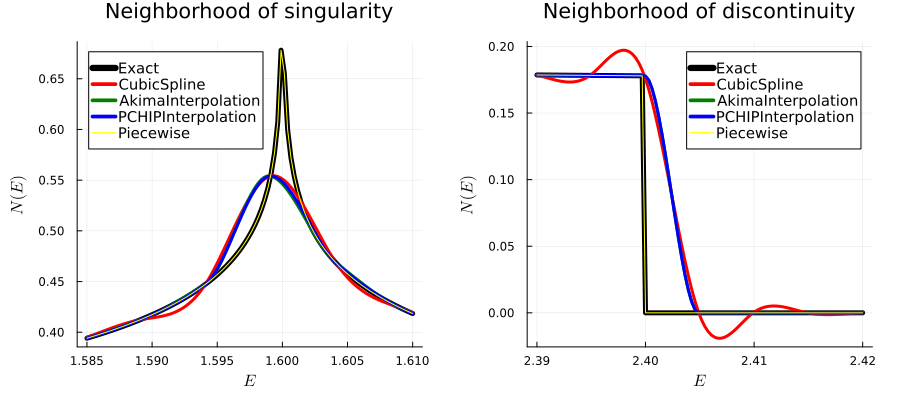

In [13]:
# Build polynomial interpolations using various models
E = LinRange(-2.5, 2.5, 1000)
g = [interp(N.(E, 0.2), E) for interp in [CubicSpline, AkimaInterpolation, PCHIPInterpolation]]

# Show memory cost of approximations
print("""

Size of interpolations     (bytes): $(Base.summarysize.(g))
Size of piecewise function (bytes): $(Base.summarysize(f))

""")

# Compare the interpolations with N(E) close to the logarithmic singularity
p1 = plot(xlabel=L"E", ylabel=L"N(E)", title="Neighborhood of singularity", legend=:topleft, legendfontsize=10)
E = LinRange(1.585, 1.61, 100)
plot!(p1, E, N.(E, 0.2), lw=5, c=:black, label="Exact")
plot!(p1, E, g[1].(E), lw=3, c=:red, label="CubicSpline")
plot!(p1, E, g[2].(E), lw=3, c=:green, label="AkimaInterpolation")
plot!(p1, E, g[3].(E), lw=3, c=:blue, label="PCHIPInterpolation")
plot!(p1, E, f.(E), lw=1, c=:yellow, label="Piecewise")

# Compare the interpolations with N(E) close to the discontinuity
p2 = plot(xlabel=L"E", ylabel=L"N(E)", title="Neighborhood of discontinuity", legend=:topright, legendfontsize=10)
E = LinRange(2.39, 2.42, 100)
plot!(p2, E, N.(E, 0.2), lw=5, c=:black, label="Exact")
plot!(p2, E, g[1].(E), lw=3, c=:red, label="CubicSpline")
plot!(p2, E, g[2].(E), lw=3, c=:green, label="AkimaInterpolation")
plot!(p2, E, g[3].(E), lw=3, c=:blue, label="PCHIPInterpolation")
plot!(p2, E, f.(E), lw=1, c=:yellow, label="Piecewise")

plot(p1, p2, size = (900, 400), margins=5mm)

To conclude, we want to compare the times it takes to compute `N(E)` and `f(E)`. For a fair comparison, we should seek the same accuracy in both calculations. Our approximation has a relative accuracy of $4\times10^{-5}$, so we evaluate `N(E)` at the same relative accuracy. It is seen that the performance gain is not spectacular: less than a factor 2. This is presumably due to [`Piecewise`](https://github.com/ChristopheBerthod/Piecewise.jl) being not optimized. Indeed, the well-optimized interpolations, that hold much more information in memory than the piecewise function, are at least two orders of magnitude faster.

In [14]:
E = LinRange(-2.2, 2.2, 10000)
# Force compilation
N.(E, 0.2, tol=4e-5)
f.(E)

@time N.(E, 0.2, tol=4e-5);
@time f.(E);

  0.031347 seconds (13.41 k allocations: 4.917 MiB)
  0.022531 seconds (649.14 k allocations: 14.152 MiB)


In [15]:
g[1].(E)
@time g[1].(E);

  0.000653 seconds (4 allocations: 78.375 KiB)


## Appendix

The DOS of the anisotropic square lattice is (because the dispersion $\varepsilon(\mathbf{k})$ is periodic, the integration is limited to $k_x\in[-\pi,\pi]$ and $k_y\in[-\pi,\pi]$):
	\begin{align*}
		N(E)&=\frac{1}{(2\pi)^2}\int_{-\pi}^{\pi}dk_x\int_{-\pi}^{\pi}dk_y\,
		\delta\left(E-2\cos k_x-2\alpha\cos k_y\right)
        =\frac{4}{(2\pi)^2}\int_0^{\pi}dk_x\int_0^{\pi}dk_y\,
		\frac{1}{2}\delta\left(E/2-\cos k_x-\alpha\cos k_y\right)\\
        &=\frac{1}{2\pi^2}\int_{-1}^1\,\frac{du}{\sqrt{1-u^2}}\int_{-1}^1\,\frac{dv}{\sqrt{1-v^2}}\,
		\delta(E/2-u-\alpha v).
	\end{align*}
The second equal sign uses the facts that $\cos(k)=\cos(-k)$ and $\delta(cx)=\frac{1}{|c|}\delta(x)$. The third equal sign results after the changes of variable $u=\cos k_x$ and $v=\cos k_y$. The delta function is satisfied if $u=E/2-\alpha v$, which is only possible if $-1<E/2-\alpha v<1$, in other words $(E/2-1)/\alpha<v<(E/2+1)/\alpha$, given the limits of integration. Therefore,
	\begin{equation*}
		N(E)=\frac{1}{2\pi^2}\int_{\max\big(-1,(E/2-1)/\alpha\big)}^{\min\big(+1,(E/2+1)/\alpha\big)}\,
        \frac{dv}{\sqrt{1-v^2}}\frac{1}{\sqrt{1-(E/2-\alpha v)^2}}.
	\end{equation*}
The expression is simpler if we turn back to an angle integration using the change of variable $v=\cos\theta$:
	\begin{equation*}
		N(E)=\frac{1}{2\pi^2}\int_{\cos^{-1}\Big(\min\big(+1,(E/2+1)/\alpha\big)\Big)}
        ^{\cos^{-1}\Big(\max\big(-1,(E/2-1)/\alpha\big)\Big)}
        \frac{d\theta}{\sqrt{1-\left(E/2-\alpha\cos\theta\right)^2}}.
	\end{equation*}
The logarithmic singularity of the DOS is due to the saddle points at $(k_x,k_y)=(0,\pm\pi), (\pm\pi,0)$. Each of these points contributes equally with weight $1/4$ to the integral, so we can center the integration domain on one of them, say $(0,\pi)$, to study the singularity. Around $\mathbf{k}=(0,\pi)$, the dispersion is $\varepsilon(\mathbf{p})=E_s-p_x^2+\alpha p_y^2$, where $\mathbf{p}=\mathbf{k}-(0,\pi)$ and $E_s=2(1-\alpha)$ is the enegy of the singularity. The DOS at $\Delta E=E-E_s$ is
\begin{equation*}
    N(\Delta E\to 0)=\frac{1}{(2\pi)^2}\int_{-\pi}^{\pi}dp_x\int_{-\pi}^{\pi}dp_y\,\delta\left(\Delta E+p_x^2-\alpha p_y^2\right)
    =\frac{4}{(2\pi)^24\sqrt{\alpha}}\int_0^{\pi^2}\frac{du}{\sqrt{u}}
    \int_0^{\alpha\pi^2}\frac{dv}{\sqrt{v}}\,\delta(\Delta E+u-v),
\end{equation*}
where we have used the symmetries and changed variable to $u=p_x^2$ and $v=\alpha p_y^2$. The delta function is satisfied if $v=\Delta E+u$, which is only possible if $0<\Delta E+u<\alpha\pi^2$.
Therefore
\begin{equation*}
    N(\Delta E\to 0)=\frac{1}{4\pi^2\sqrt{\alpha}}
    \int_{\max(0,-\Delta E)}^{\min(\pi^2,\alpha\pi^2-\Delta E)}\frac{du}{\sqrt{u}\sqrt{\Delta E+u}}
    =\frac{1}{4\pi^2\sqrt{\alpha}}\left[-2\ln\left(\sqrt{\Delta E+u}-\sqrt{u}\right)\right]
    _{\max(0,-\Delta E)}^{\min(\pi^2,\alpha\pi^2-\Delta E)}.
\end{equation*}
Since we assume $\alpha<1$ and we take the limit $\Delta E\to0$, the upper bound is $\alpha\pi^2-\Delta E$. Considering the two cases $\Delta E>0$ and $\Delta E<0$ and keeping only the singular term, we arrive at
\begin{equation*}
    N(\Delta E\to 0)=-\frac{1}{4\pi^2\sqrt{\alpha}}\ln|\Delta E|.
\end{equation*}